In [1]:
from toybox.interventions.amidar import *
from toybox.interventions.breakout import *
from toybox.interventions.base import *
from toybox.interventions.core import * 
from toybox import Toybox, Input

import numpy as np
import math
from matplotlib.pyplot import imshow, subplots, tight_layout
import random

Loaded Toybox environments.


In [2]:
def calc_distance(one, two):
    
    return abs(one.tx -  two.tx) + abs(one.ty - two.ty)

In [3]:
def get_walls(tiles):
    
    walls = []
    
    for i in range(len(tiles)):
        for j in range(len(tiles[i])):
            if tiles[i][j] == 'Empty':
                coord = (i,j)
                walls.append(coord)
    return walls
    

In [4]:
def available_moves(pos, intervention): #returns a list of available "legal" moves in the format 
    #[up, down, left, right] given the current position of the agent
    
    possible_actions = [True] * 4
    
    x = pos.tx
    y = pos.ty
      
    
    try:
        tile = intervention.get_tile_by_pos(x + 1, y) #Can't move right...
        possible_actions[3] = False if tile.tag == "Empty" else True
    except:
        possible_actions[3] = False
    
    try: 
        tile = intervention.get_tile_by_pos(x - 1, y) #Can't move left...
        possible_actions[2] = False if tile.tag == "Empty" else True
    except:
        possible_actions[2] = False

    try: 
        tile = intervention.get_tile_by_pos(x, y - 1) #Can't move down...
        possible_actions[1] = False if tile.tag == "Empty" else True
    except:
        possible_actions[1] = False
        
    try: 
        tile = intervention.get_tile_by_pos(x, y + 1) #Can't move up...
        possible_actions[0] = False if tile.tag == "Empty" else True
    except:
        possible_actions[0] = False
    

    return possible_actions 

In [5]:
def gen_adj_move(direction, move,  moves):
    #generates a move that is adjacent to the current one (i.e: not opposite direction)
    
    
    direct = direction
    
    if direction == "up" or direction == "down":  
        if moves[2]:
            setattr(move, 'left', True)
            setattr(move, direction, False)
            direct = 'left'
        elif moves[3]:
            setattr(move, 'right', True)
            setattr(move, direction, False)
            direct = 'right'
    if direction == "left" or direction == "right":
        if moves[0]:
            setattr(move, 'up', True)
            setattr(move, direction, False)
            direct = 'up'
        elif moves[1]:
            setattr(move, 'down', True)
            setattr(move, direction, False)
            direct = 'down'
    
    return (move, direct)

{'left': False, 'right': False, 'up': True, 'down': False, 'button1': False, 'button2': False} ['up', 'up'] [True, True, False, False]
{'left': False, 'right': False, 'up': True, 'down': False, 'button1': False, 'button2': False} ['up', 'up', 'up'] [True, True, False, False]
{'left': False, 'right': False, 'up': True, 'down': False, 'button1': False, 'button2': False} ['up', 'up', 'up', 'up'] [True, True, False, False]
{'left': True, 'right': False, 'up': False, 'down': False, 'button1': False, 'button2': False} ['up', 'up', 'up', 'up', 'up'] [True, True, True, False]
{'left': True, 'right': False, 'up': False, 'down': False, 'button1': False, 'button2': False} ['up', 'up', 'up', 'up', 'up', 'up'] [False, False, True, True]
{'left': True, 'right': False, 'up': False, 'down': False, 'button1': False, 'button2': False} ['up', 'up', 'up', 'up', 'up', 'up', 'up'] [False, False, True, True]
{'left': True, 'right': False, 'up': False, 'down': False, 'button1': False, 'button2': False} ['up',

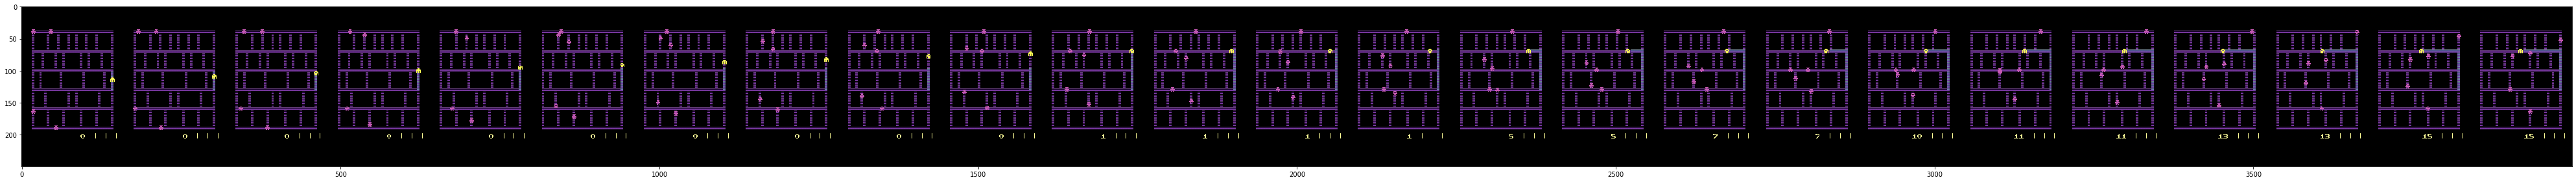

In [6]:
move = Input()
move.up = True
direction = "up"
last_move = direction
move_changed = []


frames = []
enemy_hist = []
direction_hist = []
direction_hist.append(direction)
with Toybox('amidar') as tb:    
    
    for i in range(250):
        tb.apply_action(move)
        
        if i % 10 == 0:
            
            with AmidarIntervention(tb) as intervention:

                game = intervention.game
                player_pos = intervention.worldpoint_to_tilepoint(game.player.position) 
                enemy_pos_0 = intervention.worldpoint_to_tilepoint(game.enemies[0].position)
                enemy_pos_1 = intervention.worldpoint_to_tilepoint(game.enemies[1].position) 
                enemy_pos_2 = intervention.worldpoint_to_tilepoint(game.enemies[2].position)  
                enemy_pos_3 = intervention.worldpoint_to_tilepoint(game.enemies[3].position) 
                
                

                vals = [calc_distance(player_pos, enemy_pos_0), calc_distance(player_pos, enemy_pos_1), 
                        calc_distance(player_pos, enemy_pos_2), calc_distance(player_pos, enemy_pos_3)]
                #Returns the Manhattan distance of the closest enemy to the agent
                enemy_idx, closest_dist = min(enumerate(vals), key = lambda p: p[1])
                
                
                if closest_dist <= 27: 
                #If enemy is within range, 1) check available moves, 2)generate an adjacent move, 3)update metrics
                        
                        
                            enemy_hist.append(enemy_idx)
                            available = available_moves(player_pos, intervention)
                            generated = gen_adj_move(direction,move, available)
                            sample_direction = generated[1]
                                
                            if len(direction_hist) <= 1:
                                move = generated[0]
                                direction = sample_direction
                                move_changed.append(True)

                            elif direction_hist[-1] == direction_hist[-2] and move_changed[-1:-3] is False:
                                move = generated[0]
                                direction = sample_direction
                                move_changed.append(True)
                            else:
                                move_changed.append(False)
                            
                            direction_hist.append(direction)

                            print(move, direction_hist, available)

                
                frames.append(tb.get_rgb_frame())



        
subplots(figsize=(len(frames)*3, 4))
imshow(np.hstack(frames))
tight_layout() # makes it a little bigger.